In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, bisect, minimize
from scipy.interpolate import interp1d, LinearNDInterpolator

from ifront_guess import surface_density

import astropy.units as u

In [3]:
from astropy.constants import R as R_gas, G
k = 1e-2 * u.cm**2/u.g # opacity

In [4]:
def speed_of_sound(T, mu):
    """Find speed of soundin a gas from temperature and mean molecular mass.

    Parameters
    ----------
    T : float
        Temperature in Kelvin.
    mu : float
        Mean molecular mass in unit of hydrogen atoms.

    Returns
    -------
    float
       Speed of sound.
    """
    return np.sqrt(R_gas*T/mu)

In [5]:
def adiabatic_factor(T, rho, mu, gamma = 5/3):
    """Find adiabatic factor K from temperature, density, mean molecular mass and adiabatic exponent.

    Parameters
    ----------
    T : float
        Temperature in Kelvin.
    rho : float
        Density in g/cm3
    mu : float
        Mean molecular mass in unit of hydrogen atoms.
    gamma : _type_
        aAiabatic exponent (usually 5/3 for nonrelativistic gas)

    Returns
    -------
    _type_
        _description_
    """
    return (R_gas*T)/(mu * rho**(gamma - 1))

### Mass-radius relation
For nonrelativistic degenerate objects:

$$RM^{1/3} = \eta$$

so for given $\eta$:
$$M = \bigg(\frac{\eta}{R}\bigg)^3 $$

In [6]:
# Find core radius from mass
def degenerate_core_radius(M_o):
    """Find radius of core from its mass assuming it's composed of degenerate matter.

    Parameters
    ----------
    M_o : float
        Mass of stellar core.

    Returns
    -------
    float
        Radius of stellar core
    """
    M_wd = (1898.13 * 1e24 * u.kg).to(u.solMass)
    R_wd = (71492 * u.km).to(u.astronomical_unit)
    eta = R_wd*((M_wd)**(1/3))
    return eta*M_o**(-1/3)

## To do:

- How core mass and radius are related to other parameters?
- Find core radius by shooting inwards and matching temperature profile (know T at atmosphere and core), profile is adiabatic
$$T(R_s) = F(R_s, T(R_o))$$
- Match mass:
$$M_e = M_s - M_o$$
$$M_e = \int_{R_o}^{R_s} \rho (R) dR = M_e(R_s)$$
- Find radius after mass has been removed

## Adiabatic profile

Assuming $P = K\rho^{\gamma}$ and hydrostatic balance ($\frac{dP}{dR} = -\frac{G M(<R)}{R^2} \rho$) one obtains:
$$\frac{dT}{dR} = - \frac{\gamma - 1}{\gamma}\frac{\mu}{R_{gas}}g$$
where $g = \frac{GM(<R)}{R^2}$ is the local acceleration of gravity

## Reframe equation
Three quantities, T and $m = M(<R)$ and $\rho$.

$$\frac{dT}{dR} = - \frac{\gamma - 1}{\gamma}\frac{\mu}{R_{gas}}\frac{Gm}{R^2}$$
$$\frac{dm}{dR} = 4 \pi R^2 \rho(R)$$
$$\frac{d \rho}{dR} = - \frac{G}{K \gamma} \frac{m \rho^{2-\gamma}}{R^2}$$

with boundary conditions:

$$T(R_s) = T_s$$
$$m(R_s) = M_s$$
$$\rho(R_s) = \rho_s$$



In [7]:
# Cast differential equation to function
def profile_fun(R, y, gamma, K, mu):
    """Recasting of differential equation for numerical integration.

    Parameters
    ----------
    R : float
        Radial distance from the center of the star.
    y : list
        List of three arrays with the same length as R. They represent temperature (T), mass (m) and density (rho) respectively.
    gamma : float
        Adiabatic exponent
    K : float
        Adiabatic factor, proportionality constant between pressure and power of density.
    mu : float
        Mean molecular mass in unit of hydrogen atoms.

    Returns
    -------
    list
        List of three arrays with the same length as R. They represent the R derivatives of temperature (T), mass (m) and density (rho) respectively.
    """
    dTdR = (- (gamma - 1)/gamma)*(mu*G.value/R_gas.value)*(y[1]/R**2)
    dmdR = 4*np.pi*(R**2)*y[2]
    drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)
    return [dTdR, dmdR, drhodR]

In [8]:
# Remove units for calculation
def remove_units(vals):
    bases = [u.astronomical_unit, u.solMass, u.K, u.a, u.mol]
    res = []
    for val in vals:
        convert = val
        if isinstance(val, u.quantity.Quantity):
            convert = val.decompose().value
        res.append(convert)
    return tuple(res)

In [9]:
def adiabatic_profile(R_s, T_s, M_s, M_o, gamma, mu):
    """Numerically integrate shooting inwards to find temperature, enclosed mass and density as a function of radial distance from the surface of the star.

    Parameters
    ----------
    R_s : float
        Guess of outer radius of the star.
    T_s : float
        Guess of surface temperature of the star.
    M_s : float
        Mass of the star.
    M_o : float
        Mass of the helium core of the star.
    gamma : float
        Adiabatic exponent.
    mu : float
        Mean molecular mass in unit of hydrogen atoms.

    Returns
    -------
    _type_
        _description_
    """
    # Integrate shooting inwards to find density profile
    c_s = speed_of_sound(T_s, mu)
    rho_s = 1e-12 * u.g / u.cm**3 # pick small value since density gets arbitrarily low at the surface
    K = adiabatic_factor(T_s, rho_s, mu, gamma)
    R_o = degenerate_core_radius(M_o) # Find core radius by knowing core is degenerate

    #remove units for integration
    R_s, R_o, T_s, M_s, rho_s, K, mu = remove_units((R_s, R_o, T_s, M_s, rho_s, K, mu))
    
    # Integration span
    R_span = [R_s, R_o] 
    R_eval = np.linspace(R_s, R_o, 500)

    # Set initial conditions
    y0 = [T_s, M_s, rho_s]

    # Solve
    sol = solve_ivp(profile_fun, R_span, y0 = y0, args=(gamma, K, mu), t_eval=R_eval)
    return sol

## Try for some values

In [10]:
# Fixed parameter list
mu = 0.5 * u.g / u.mol # mean molecular weight in units of hydrogen mass
M_s = 1.5 * u.solMass # Star mass
M_o = 0.075 * u.solMass # Core mass
gamma = 4/3 + 1e-12 # Adiabatic exponent
T_o = 4e6 *u.K # Hydrogen burning temperature

R_o = degenerate_core_radius(M_o) # Core radius
print(M_o, R_o)
print((M_o/R_o**3).decompose())

0.075 solMass 0.00011157964135706012 AU
32065355.12860304 kg / m3


In [11]:
# Assume initial values
R_s = 2 * u.astronomical_unit
T_s = 318.7196287716579 * u.K  

# Solve
sol = adiabatic_profile(R_s, T_s, M_s, M_o, gamma, mu)

# Cast solution to separate variables and convert to sensible units
T = sol.y[0] 
m = (sol.y[1] * u.kg).to(u.solMass)
rho = (sol.y[2] * u.kg / (u.m**3)).to("g/cm3")
R = (sol.t * u.m).to(u.astronomical_unit)

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_7161/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


In [12]:
print(T[0], T[-1], T_o)
print(m[0], m[-1], M_o)
print(rho[0], rho[-1])
print(R[0], R[-1])

318.7196287716579 4000000.000991295 4000000.0 K
1.5 solMass 0.03308232084124468 solMass 0.075 solMass
9.999999999999998e-13 g / cm3 1.9770107927026794 g / cm3
1.9999999999999998 AU 0.00011157964135706011 AU


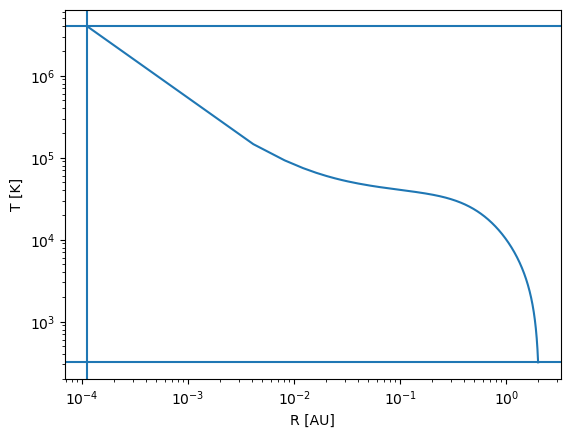

In [13]:
# Plot Temperature
plt.loglog(R, T)
plt.ylabel("T [K]")
plt.xlabel("R [AU]")
plt.axhline(T_o.value)
plt.axhline(T_s.value)
plt.axvline(R_o.value)

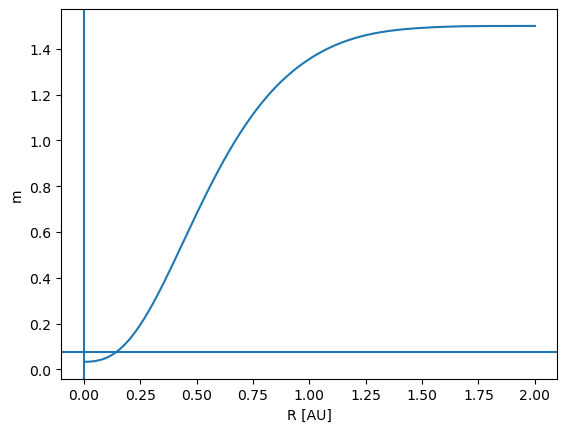

In [14]:
# Plot mass
plt.plot(R, m.to(u.solMass).value)
plt.ylabel("m")
plt.xlabel("R [AU]")
plt.axhline(M_o.to(u.solMass).value)
plt.axvline(R_o.value)

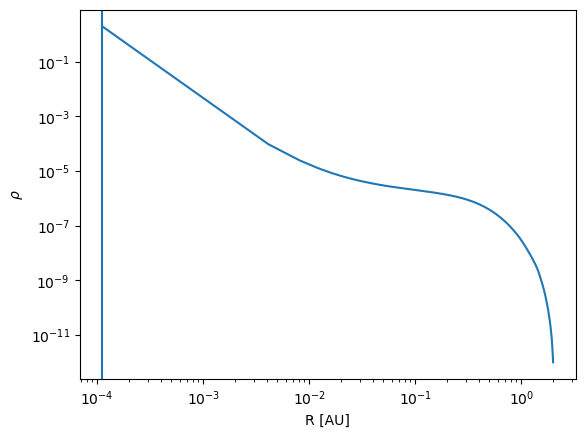

In [15]:
plt.loglog(R, rho.value)
plt.ylabel(r"$\rho$")
plt.xlabel("R [AU]")
#plt.axhline(M_o.to(u.solMass).value)
plt.axvline(R_o.value)

## Evaluate temperature error

In [75]:
# Calculate distance from expected values
def core_temp_error(R_s, T_s, M_s, M_o, gamma, mu, T_o):
    R_o = degenerate_core_radius(M_o)
    sol = adiabatic_profile(R_s, T_s, M_s, M_o, gamma, mu)
    T_res = sol.y[0]
    error = T_res[-1] - T_o.value
    return error

In [76]:
R_list = np.linspace(0.3, 4, 200) * u.astronomical_unit
err = []
for i, R in enumerate(R_list):
    err.append(core_temp_error(R, T_s, M_s, M_o, gamma, mu, T_o))

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_56323/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


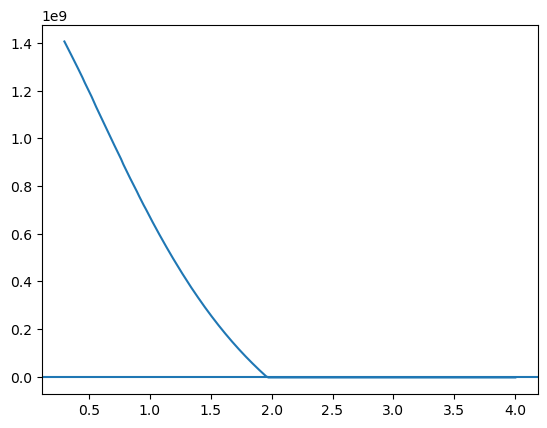

In [77]:
plt.plot(R_list, err)
plt.axhline(0)

In [78]:
# Find star radius from known properties of core
def star_radius(T_s, M_s, M_o, gamma, mu, T_o):
    guess_1, guess_2 = (0.3 * u.astronomical_unit).decompose().value, (4 * u.astronomical_unit).decompose().value
    args = (T_s, M_s, M_o, gamma, mu, T_o)
    R_s = brentq(core_temp_error, guess_1, guess_2, args=args)
    return R_s

In [79]:
print(T_s)
R_s = (star_radius(T_s, M_s, M_o, gamma, mu, T_o) * u.m).to(u.astronomical_unit)
print(R_s)

10.0 K


/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_56323/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


1.9572963673517672 AU


## Evaluate mass error

In [80]:
def core_mass_error(R_s, T_s, M_s, M_o, gamma, mu):
    R_o = degenerate_core_radius(M_o)
    sol = adiabatic_profile(R_s, T_s, M_s, M_o, gamma, mu)
    m_res = sol.y[1]
    error = m_res[-1] - M_o.to(u.kg).value
    return error

In [81]:
def core_error(T_s, M_s, M_o, gamma, mu, T_o):
    R_s = star_radius(T_s, M_s, M_o, gamma, mu, T_o)
    error = core_mass_error(R_s, T_s, M_s, M_o, gamma, mu)
    return error

In [82]:
N = 200
T_list = np.linspace(0.5e3, 1e4,N)
R_list = np.zeros(N)
err = np.zeros(N)
for i, T in enumerate(T_list):
    try:
        R = star_radius(T, M_s, M_o, gamma, mu, T_o)
        R_list[i] = R
        err[i] = core_error(T, M_s, M_o, gamma, mu, T_o)
    except ValueError as v:
        print(T, v)

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_56323/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


500.0 f(a) and f(b) must have different signs
547.7386934673367 f(a) and f(b) must have different signs
595.4773869346734 f(a) and f(b) must have different signs
643.21608040201 f(a) and f(b) must have different signs
690.9547738693467 f(a) and f(b) must have different signs
738.6934673366834 f(a) and f(b) must have different signs
786.4321608040201 f(a) and f(b) must have different signs
834.1708542713568 f(a) and f(b) must have different signs
881.9095477386934 f(a) and f(b) must have different signs
929.6482412060302 f(a) and f(b) must have different signs
977.3869346733668 f(a) and f(b) must have different signs
1025.1256281407036 f(a) and f(b) must have different signs
1072.8643216080402 f(a) and f(b) must have different signs
1120.6030150753768 f(a) and f(b) must have different signs
1168.3417085427136 f(a) and f(b) must have different signs
1216.0804020100502 f(a) and f(b) must have different signs
1263.8190954773868 f(a) and f(b) must have different signs
1311.5577889447236 f(a

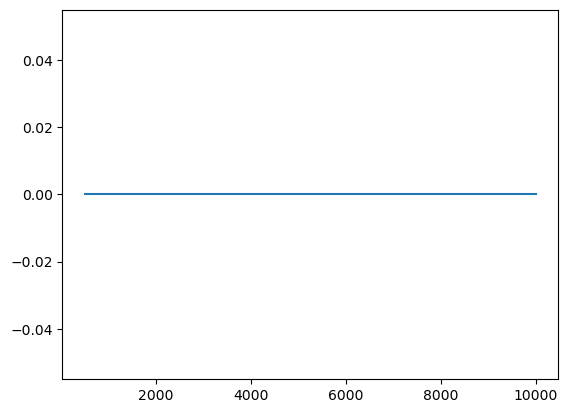

In [83]:
plt.plot(T_list, R_list)

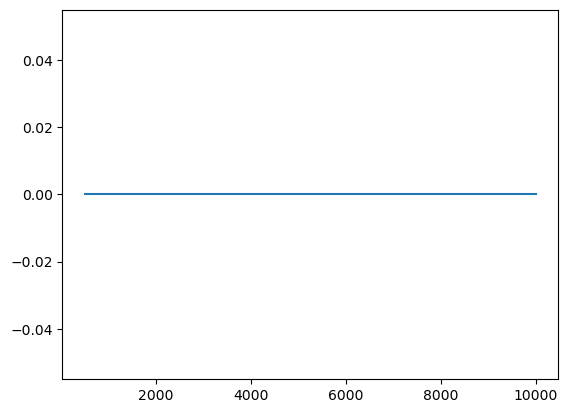

In [84]:
plt.plot(T_list, (err * u.kg ).to(u.solMass))

In [85]:
def core_error(T_s, M_s, M_o, gamma, mu, T_o):
    try:
        R_s = star_radius(T_s, M_s, M_o, gamma, mu, T_o)
        error = core_mass_error(R_s, T_s, M_s, M_o, gamma, mu)
        return error
    except ValueError as v:
        return 1

In [86]:
def star_surface_temperature(M_s, M_o, gamma, mu, T_o):
    guess_1, guess_2 = 100, 10_000
    args = (M_s, M_o, gamma, mu, T_o)
    T_s = brentq(core_error, guess_1, guess_2, args=args)
    return T_s

In [87]:
T_s = star_surface_temperature(M_s, M_o, gamma, mu, T_o)
print(T_s)
R_s = star_radius(T_s, M_s, M_o, gamma, mu, T_o)
print(R_s)

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_56323/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


ValueError: f(a) and f(b) must have different signs

## Other way around

In [151]:
# Fixed parameter list
mu = 0.5 * u.g / u.mol # mean molecular weight in units of hydrogen mass
gamma = 4/3 # Adiabatic exponent
T_o = 4e6 *u.K # Hydrogen burning temperature

M_s = 1.5 * u.solMass # Star mass
M_o = 0.040 * u.solMass # Core mass

M_o = 0.29999999999999993 * u.solMass
M_s = 0.040033783783783784 * u.solMass

R_o = degenerate_core_radius(M_o) # Core radius
print(M_o, R_o)
print((M_o/R_o**3).decompose())

0.29999999999999993 solMass 7.02907694427403e-05 AU
513045682.05764854 kg / m3


In [152]:
# Calculate distance from expected values
def core_temp_error(T_s, R_s, M_s, M_o, gamma, mu, T_o):
    R_o = degenerate_core_radius(M_o)
    sol = adiabatic_profile(R_s, T_s, M_s, M_o, gamma, mu)
    T_res = sol.y[0]
    error = T_res[-1] - T_o.value
    return error

In [153]:
R_s = 2 * u.astronomical_unit
N = 200
T_list = np.linspace(1, 10000, N) * u.K
err = np.zeros(N)
for i, T in enumerate(T_list):
    try:
        err[i] = core_temp_error(T, R_s, M_s, M_o, gamma, mu, T_o)
    except IndexError as v:
        print(T, v)

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_7161/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


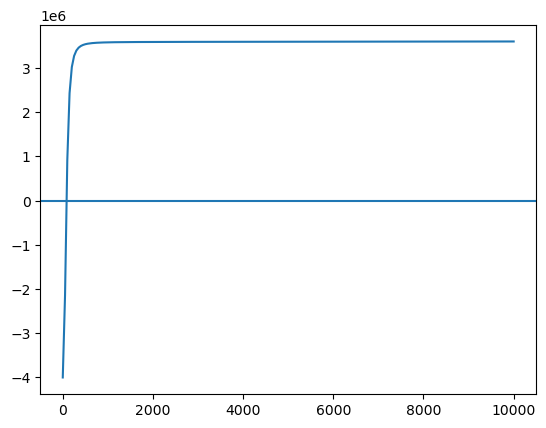

In [154]:
plt.plot(T_list, err)
plt.axhline(0)

In [155]:
# Find star radius from known properties of core
def star_surface_temperature(R_s, M_s, M_o, gamma, mu, T_o):
    guess_1, guess_2 = 1, 5e4
    args = (R_s, M_s, M_o, gamma, mu, T_o)
    R_s = brentq(core_temp_error, guess_1, guess_2, args=args)
    return R_s

In [156]:
print(R_s)
T_s = (star_surface_temperature(R_s, M_s, M_o, gamma, mu, T_o) * u.K)
print(T_s)

2.0 AU


/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_7161/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


83.93781631166243 K


In [157]:
def core_mass_error(R_s, T_s, M_s, M_o, gamma, mu):
    R_o = degenerate_core_radius(M_o)
    sol = adiabatic_profile(R_s, T_s, M_s, M_o, gamma, mu)
    m_res = sol.y[1]
    error = m_res[-1] - M_o.to(u.kg).value
    return error

In [158]:
def core_error(R_s, M_s, M_o, gamma, mu, T_o):
    try:
        T_s = star_surface_temperature(R_s, M_s, M_o, gamma, mu, T_o)
        error = core_mass_error(R_s, T_s, M_s, M_o, gamma, mu)
        return (error * u.kg).to(u.solMass)
    except ValueError as V:
        print("core_error: ", M_s, M_o, V)
        return np.inf * u.solMass

In [159]:
N = 10
R_list = np.linspace(0.5, 4, N) * u.astronomical_unit
T_list = np.zeros(N)
err = np.zeros(N) * u.solMass
for i, R in enumerate(R_list):
    try:
        T = star_surface_temperature(R, M_s, M_o, gamma, mu, T_o)
        T_list[i] = T
        err[i] = core_error(R, M_s, M_o, gamma, mu, T_o)
    except ValueError as v:
        print(R, v)

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_7161/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


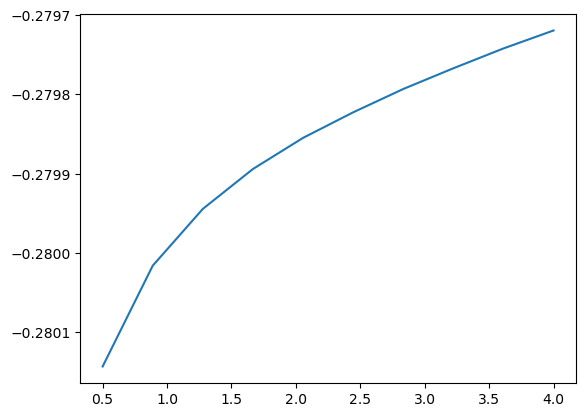

In [160]:
plt.plot(R_list, err)

In [28]:
def changes_sign(err):
    a = np.nanmin(err)
    b = np.nanmax(err)
    s = np.sign(a) * np.sign(b)
    if s <= 0:
        return True
    else:
        return False

In [427]:
changes_sign(err)

False

In [31]:
def error_over_parameters(M_s, M_o, N = 10):
    R_list = np.linspace(0.5, 4, N) * u.astronomical_unit
    err = np.zeros(N) * u.solMass
    for i, R in enumerate(R_list):
        try:
            err[i] = core_error(R, M_s, M_o, gamma, mu, T_o)
        except ValueError as v:
            print("Params: ", R, v)
            pass
    return err

In [32]:
def error_at_endpoints(M_s, M_o, gamma, mu, T_o):
    R_list = np.array([0.5, 4]) * u.astronomical_unit
    err = np.zeros(len(R_list)) * u.solMass
    for i, R in enumerate(R_list):
        try:
            err[i] = core_error(R, M_s, M_o, gamma, mu, T_o)
        except ValueError as v:
            print("endpoints:, ", R, v)
            pass
    return err

In [430]:
N = 7
M_s_range = np.linspace(0.3, 8, N + 1) * u.solMass
M_o_perc_range = np.logspace(-3, 0, N)
M_o_range = np.tensordot(M_s_range, M_o_perc_range, axes = 0)

sol = np.ones((N+1, N))

for i, M_s in enumerate(M_s_range):
    for j, M_o in enumerate(M_o_range[i]):
        val = changes_sign(error_at_endpoints(M_s, M_o, gamma, mu, T_o))
        if val: print(M_s, M_o, val)
        sol[i, j] = val
    
plt.imshow(sol)

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_835/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


KeyboardInterrupt: 

### Try different approach instead of gridsearch
- Fix M_s
- Range over M_o by minimising the error's absolute value

In [33]:
def min_error_over_mass(M_o_perc, M_s, N = 10):
    M_o = M_s*M_o_perc.item()
    err = error_over_parameters(M_s, M_o, N = 10)
    min_err = np.nanmin(np.abs(err.value))
    return min_err

In [432]:
def mass_minimize_error(M_s):
    res = minimize(min_error_over_mass, 0.04/M_s.value, args=(M_s), bounds=[(0.001, 1)], tol = 1e-1)
    #print(res)
    M_o_perc = (res.x).item()
    return M_s*M_o_perc

In [433]:
mass_minimize_error(8*u.solMass)

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_835/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


KeyboardInterrupt: 

### New approach
For each value of M_s:
- Define M_o range
- Check which range of values has a solution (changes_sign)
- Know it's located close to M_o = 0.04

In [142]:
def when_solvable(gamma, mu, T_o, N = 15):
    M_s_range = np.logspace(np.log10(0.3), np.log10(8), N) * u.solMass
    M_o_range = np.linspace(0.0375, 0.0407, 5*N) * u.solMass

    sol = np.zeros((len(M_s_range), len(M_o_range)))

    for i, M_s in enumerate(M_s_range):
        print(i)
        for j, M_o in enumerate(M_o_range):
            val = changes_sign(error_at_endpoints(M_s, M_o, gamma, mu, T_o))
            sol[i, j] = val

    return sol, M_o_range

/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_7161/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


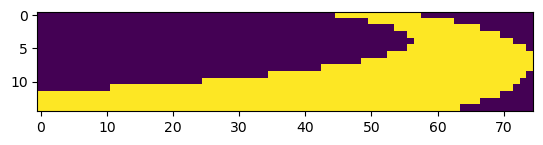

In [143]:
sol, M_o_range = when_solvable(gamma, mu, T_o)
plt.imshow(sol)
plt.show()
#print(M_s_range[5], M_o_range[20])

In [169]:
print(M_o_range[45])

0.03944594594594594 solMass


In [205]:
def sol_intervals(sol):
    intervals = []
    for row in sol:
        # Find the indices where the row switches between 0s and 1s
        indices = np.where(np.diff(row.astype(int)) != 0)[0] +  1
        # If the row starts with 1, prepend a 0 to the indices
        if row[0]:
            indices = np.insert(indices, 0, 0)
        # If the row ends with 1, append the length of the row to the indices
        if row[-1]:
            indices = np.append(indices, len(row) - 1)
        # Reshape the indices into pairs of (start, end) indices
        section_pairs = indices.reshape(-1, 2)
        # Convert the section pairs to tuples and flatten the list
        section_tuples = [val for pair in section_pairs for val in pair]
        # Append the flattened list to the list of sections
        intervals.append(section_tuples)
    # Convert the list of sections to a NumPy array and reshape it
    return np.array(intervals).reshape(-1, 2)

def solvable_matrix(sol):
    M_o_range = np.linspace(0.0375, 0.0407, 5*len(sol))
    intervals = sol_intervals(sol != 0)
    N = len(intervals)
    matrix = np.zeros((N, N+1))
    for i, interval in enumerate(intervals):
        start, end = interval
        #print(start, end-1)
        #print(sol[i, start], M_o_range[start])
        int_values = np.linspace(M_o_range[start], M_o_range[end - 1], N+1)
        matrix[i,:] = int_values
    return matrix

In [206]:
solm = solvable_matrix(sol)

(15, 16)


Text(0, 0.5, 'M_o')

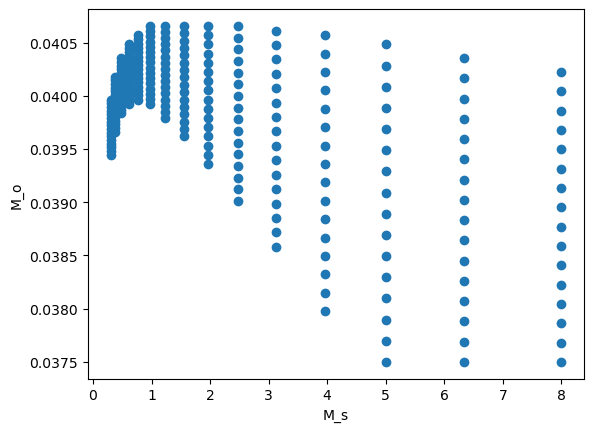

In [207]:
N = len(solm)
print(solm.shape)
M_s_range = np.tensordot(np.logspace(np.log10(0.3), np.log10(8), N), np.ones(len(solm[1])), axes = 0)
plt.scatter(M_s_range, solm)
plt.xlabel("M_s")
plt.ylabel("M_o")

In [208]:
print(solm[0, 0])

0.03944594594594594


In [209]:
def interpolate_error(M_s, M_o, gamma, mu, T_o, N = 10):
    R_list = np.linspace(0.5, 4, N) * u.astronomical_unit
    T_list = np.zeros(N)
    err = np.ones(N) * u.solMass
    for i, R in enumerate(R_list):
        try:
            T = star_surface_temperature(R, M_s, M_o, gamma, mu, T_o)
            err[i] = core_error(R, M_s, M_o, gamma, mu, T_o)
        except ValueError as v:
            print("interpolate; ", R, v)
    
    return interp1d(R_list.value, err.value)

In [210]:
def star_radius(M_s, M_o, gamma, mu, T_o):
    guess_1, guess_2 = 0.5 * u.astronomical_unit, 4 * u.astronomical_unit
    args = (M_s, M_o, gamma, mu, T_o)
    fun = interpolate_error(*args)
    #print(fun(guess_1))
    #print(fun(guess_2))
    R_s = brentq(fun, guess_1.value, guess_2.value)
    return R_s * u.astronomical_unit

In [215]:
def solve_when_solvable(solm, gamma, mu, T_o):
    N = len(solm)
    M_s_range = np.logspace(np.log10(0.3), np.log10(8), N) * u.solMass
    M_o_range = solm * u.solMass

    R_s_range = np.zeros((len(M_s_range), len(M_o_range[1]))) * u.astronomical_unit

    for i, M_s in enumerate(M_s_range):
        print(i)
        for j, M_o in enumerate(M_o_range[i]):
            #print(i, j, M_s, M_o)
            R_s = star_radius(M_s, M_o, gamma, mu, T_o)
            #print(M_s, R_s)
            R_s_range[i, j] = R_s
    
    return M_s_range, M_o_range, R_s_range

In [216]:
M_s_range, M_o_range, R_s_range = solve_when_solvable(solm, gamma, mu, T_o)

0


/var/folders/b_/4vdzp0yn5_n0jlzmh1wmgmkc0000gn/T/ipykernel_7161/646426579.py:25: RuntimeWarning: invalid value encountered in double_scalars
  drhodR = - (G.value/(gamma*K))*(y[1]*y[2]**(2-gamma)/R**2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [217]:
print(M_s_range.shape, M_o_range.shape, R_s_range.shape)

(15,) (15, 16) (15, 16)


### Save data

In [218]:
import os
def new_fname(name, path="data", form="txt"):
    """Generate file name not present in the directory from given string.

    Parameters
    ----------
    name : str
        proposed file name
    path : str, optional
        directory in which the file will be saved, use empty string for current directory, by default "data"
    form : str, optional
        format of file, eg. "txt" or "npy"
    """
    # Folder path where the files are located
    folder_path = "data"

    # Desired file name
    file_name = name
    current_file_name = file_name + "." + form
    current_file_path = os.path.join(folder_path, current_file_name)

    # Initialize the file number
    file_num = 1

    # Check if file name already exists in the folder
    while True:
        current_file_name = file_name + str(file_num) + "." + form
        current_file_path = os.path.join(folder_path, current_file_name)
        if os.path.exists(current_file_path):
            file_num += 1
        else:
            break

    return current_file_path

In [227]:
np.savetxt(new_fname("M_s_range"), M_s_range.value)
np.savetxt(new_fname("M_o_range"), M_o_range.value)

## Interpolate results to use in evolution model

In [222]:
def repack(M_s_range, M_o_range):
    points = []
    for i in range(len(M_s_range)):
        for j in range(len(M_o_range[i])):
            points.append([M_s_range[i], M_o_range[i, j]])
    return np.array(points, dtype=object)

In [223]:
points = repack(M_s_range.to(u.solMass).value, M_o_range.to(u.solMass).value)
print(points.shape)
tot = len(M_s_range) * len(M_o_range[0, :])
print(tot)
result = R_s_range.to(u.astronomical_unit).value.reshape(tot)
print(result.shape)

(240, 2)
240
(240,)


In [224]:
interp_radius = LinearNDInterpolator(points, result)

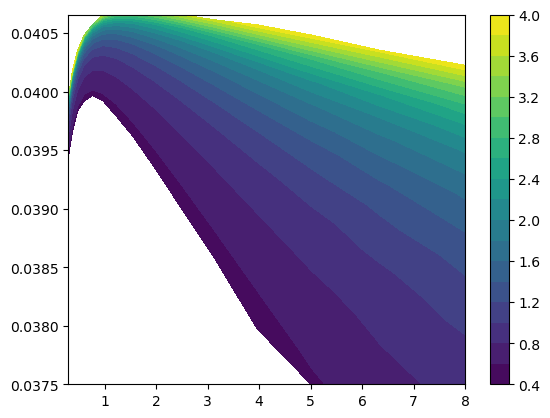

In [225]:
M_s_range_2 = np.tensordot(M_s_range, np.ones(len(M_o_range[0])), axes = 0)
plt.contourf(M_s_range_2, M_o_range, interp_radius(M_s_range_2, M_o_range), levels=20)
plt.colorbar()

In [226]:
np.save("interpolator_radius", interp_radius)

## Algorithm steps:

1. Choose $M_s(0)$, $R_o$, $\gamma$ and other parameters
2. Evaluate $T_o(M_s, R_o)$
3. Find $R_s(M_s, R_o; t)$ using star_radius function
4. Calculate mass loss rate $\dot M(M_s, R_s; t)$ using interpolated mass loss data
5. Reduce mass $M_s(t + \delta t) = M_s(t) + \dot M \delta t$, step forwards in time $t \rightarrow t + \delta t$
6. Repeat steps 3-5 until $t = t_f$


## Load interpolators

In [634]:
mass_loss = np.load("interpolator_mass_loss.npy", allow_pickle=True).item()

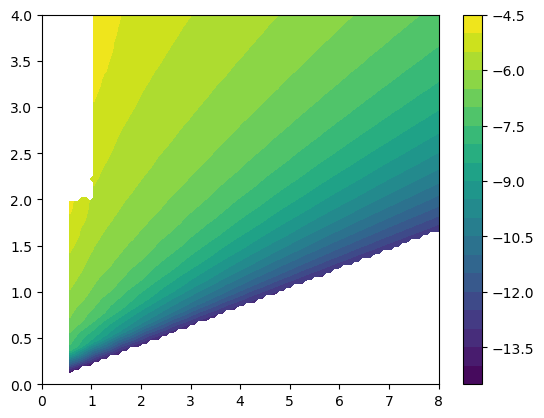

In [635]:
m_dot = 0.5
x = np.linspace(0, 8, 100)
y = np.linspace(0, 4, 100)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, mass_loss(X, Y, m_dot), 20)
plt.colorbar()

## Problem parameters:
Variable:

- Star mass $M_s$
- Star core radius $R_o$
- Black hole accretion rate $\dot m$

Constants:
- Adiabatic exponent $\gamma$
- Mean molecular mass $\mu$
- Surface opacity $k$

Calculated values:
- Core radius $R_o$ from core mass $M_o$
- Core temperature $T_o$ is constant temperature of degenerate gas
- Surface density $\rho_s$

Integrate to match:
- Core mass
- Core temperature

To find:
- Star radius $R_s$
- $K$ factor or surface temperature $T_s$

Matching mass should give star radius, matching temperature shoukd give K factor.


In [638]:
# Parameters
m_dot = 0.3

In [676]:
def star_evo(M_s, M_o, m_dot):
    R_s = (interp_radius(M_s, M_o) * u.astronomical_unit)

    # initialise arrays
    N = int(1e4) # integration steps 
    mass_t = np.zeros(N + 1) * u.solMass
    r_t = np.zeros(N + 1) * u.astronomical_unit

    t_eval = np.linspace(0, 1e8, N + 1)
    dt = (t_eval[1] - t_eval[0]) * u.a

    for i, t in enumerate(t_eval):
        mass_t[i] = M_s
        r_t[i] = R_s
        M_dot = 10**(mass_loss(M_s.value, R_s.value, m_dot)) * u.solMass / u.a
        #print(i, M_s, R_s, M_dot)
        M_s -= M_dot*dt
        R_s = (interp_radius(M_s, M_o) * u.astronomical_unit)
    
    return t_eval, mass_t, r_t

In [681]:
M_s = 1.5 * u.solMass # Star mass
M_o = 0.0404 * u.solMass # Core mass
t, m, r = star_evo(M_s, M_o, m_dot)

(1.118561408001966, 2.0655765498562797)

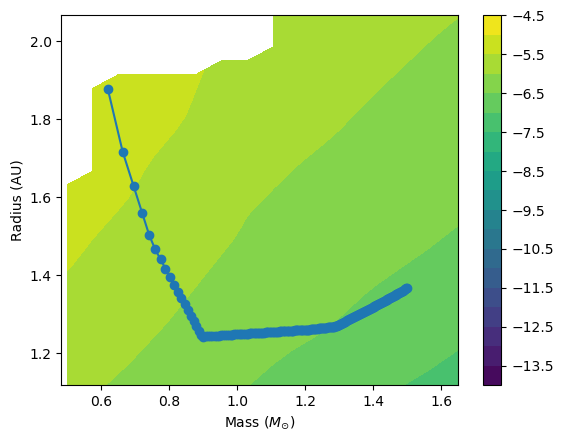

In [683]:
m_dot = 0.3
x = np.linspace(0.5, 8, 100)
y = np.linspace(0.5, 4, 100)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, mass_loss(X, Y, m_dot), 20)
plt.colorbar()

plt.plot(m.value, r.value)
plt.scatter(m.value, r.value)
plt.xlabel(r"Mass $(M_{\odot}$)")
plt.ylabel("Radius (AU)")


#plt.xlim(np.nanmin(0.9*m.value), np.nanmax(1.1*m.value))
#plt.ylim(np.nanmin(0.9*r.value), np.nanmax(1.1*r.value))